# Instances and Extensions

This chapter will cover several quantum variational algorithms, including:

- [Variational Quantum Eigensolver (VQE)](https://arxiv.org/abs/1304.3061)
- [Subspace Search VQE (SSVQE)](https://arxiv.org/abs/1810.09434)
- [Variational Quantum Deflation (VQD)](https://arxiv.org/abs/1805.08138)
- [Quantum Sampling Regression (QSR)](https://arxiv.org/pdf/2012.02338)

By using these algorithms, we will learn about several design ideas that can be incorporated into custom variational algorithms, such as weights, penalties, oversampling, and undersampling. We encourage you to experiment with these concepts and share your findings with the community.

The Qiskit patterns framework applies to all these algorithms - but we will explicitly call out the steps only in the first example.

## Table of Contents

1. [Variational Quantum Eigensolver (VQE)](#variational-quantum-eigensolver-vqe)  
   - [Step 1: Map classical inputs to a quantum problem](#step-1-map-classical-inputs-to-a-quantum-problem)  
   - [VQE's Theoretical Layout](#vqes-theoretical-layout)  
   - [VQE Implementation](#vqe-implementation)  
   - [Step 2: Optimize problem for quantum execution](#step-2-optimize-problem-for-quantum-execution)  
   - [Step 3: Execute using Qiskit Runtime Primitives](#step-3-execute-using-qiskit-runtime-primitives)  
   - [Step 4: Post-process, return result in classical format](#step-4-post-process-return-result-in-classical-format)  
2. [Subspace Search VQE (SSVQE)](#subspace-search-vqe-ssvqe)  
   - [SSVQE's Theoretical Layout](#ssvqes-theoretical-layout)  
3. [Variational Quantum Deflation (VQD)](#variational-quantum-deflation-vqd)  
   - [VQD's Theoretical Layout](#vqds-theoretical-layout)  
   - [VQD's Implementation](#vqds-implementation)  
4. [Quantum Sampling Regression (QSR)](#quantum-sampling-regression-qsr)  
   - [QSR's Theoretical Layout](#qsrs-theoretical-layout)  
5. [Summary](#summary)


## Variational Quantum Eigensolver (VQE)
VQE is one of the most widely used variational quantum algorithms, setting up a template for other algorithms to build upon.

![alt text](../../../img/instances_VQE.svg)

### Step 1: Map classical inputs to a quantum problem




### VQE’s theoretical layout

VQE’s layout is simple:

- Prepare reference operators $U_R$  
  – We start from the state $|0\rangle$ and go to the reference state $|\rho\rangle$
- Apply the variational form $U_V(\vec{\theta}_{i,j})$ to create an ansatz $U_A(\vec{\theta}_{i,j})$  
  – We go from the state $|\rho\rangle$ to $U_V(\vec{\theta}_{i,j})|\rho\rangle = |\psi(\vec{\theta}_{i,j})\rangle$
- Bootstrap at $i = 0$ if we have a similar problem (typically found via classical simulation or sampling)  
  – Each optimizer will be bootstrapped differently, resulting in an initial set of parameter vectors $\Theta_0 := \vec{\theta}_{0,j} \in \mathcal{T}_{\text{opt}}$ (e.g., from an initial point $\vec{\theta}_0$).
- Evaluate the cost function $C(\vec{\theta}_{i,j}) := \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle$ for all prepared states on a quantum computer.
- Use a classical optimizer to select the next set of parameters $\Theta_{i+1}$.
- Repeat the process until convergence is reached.

This is a simple classical optimization loop where we evaluate the cost function. Some optimizers may require multiple evaluations to calculate a gradient, determine the next iteration, or assess convergence.

Here’s the example for the following observable:

$$
\hat{O}_1 = 2II - 2XX + 3YY - 3ZZ
$$



### VQE Implementation


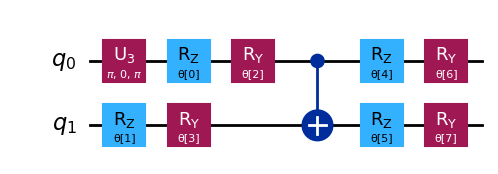

In [16]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable=SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [17]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [18]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [19]:
# We can use this cost function to calculate optimal parameters
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999988971089
       x: [ 1.779e+00  9.443e-01  1.571e+00  2.105e-05  1.938e+00
            1.204e+00  6.059e-01  6.059e-01]
    nfev: 136
   maxcv: 0.0

### Step 2: Optimize problem for quantum execution

We will select the least-busy backend, and import the necessary components form qiskit_ibm_runtime.


In [20]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)
print(backend)

AccountNotFoundError: 'Unable to find account.'

We will transpile the circuit using the preset pass manager with optimization level 3, and we will apply the corresponding layout to the observable.

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)

NameError: name 'backend' is not defined

### Step 3: Execute using Qiskit Runtime Primitives

We are now ready to run our calculation on IBM Quantum™ hardware. Because the cost function minimization is highly iterative, we will start a Runtime session. This way, we will only have to wait in a queue once. Once the job begins running, each iteration with updates to parameters will run immediately.


In [ ]:
x0 = np.ones(8)

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options = estimator_options)

    result = minimize(cost_func_vqe, x0, args=(isa_ansatz, isa_observable, estimator), method="COBYLA", options={'maxiter': 200, 'disp': True})
session.close()
print(result)

NameError: name 'backend' is not defined

### Step 4: Post-process, return result in classical format
We can see that the minimization routine successfully terminated, meaning we reached the default tolerance of the COBYLA classical optimizer. If we require a more precise result, we can specify a smaller tolerance. This may indeed be the case, since the result was several percent off compared to the result obtained by the simulator above.

The value of x obtained is the current best guess for the parameters that minimize the cost function. If iterating to obtain a higher precision, those values should be used in place of the x0 initially used (a vector of ones).

Finally, we note that the function was evaluated 96 times in the process of optimization. That might be different from the number of optimization steps, since some optimizers require multiple function evaluations in a single step, such as when estimating a gradient.


## Subspace Search VQE (SSVQE)

[SSVQE](https://qiskit.org/textbook/ch-quantum-hardware/ssvqe.html) is a variant of VQE that allows obtaining the first $k$ eigenvalues of an observable $\hat{H}$ with eigenvalues $\{\lambda_0, \lambda_1, \dots, \lambda_{N-1}\}$, where $N \geq k$. Without loss of generality, we assume that $\lambda_0 < \lambda_1 < \dots < \lambda_{N-1}$. SSVQE introduces a new idea by adding weights to help prioritize optimizing for the term with the largest weight.


![alt text](../../../img/instances_SSVQE.svg)

To implement this algorithm, we need $k$ mutually orthogonal reference states $\{|\rho_j\rangle\}_{j=0}^{k-1}$, meaning $\langle \rho_j | \rho_l \rangle = \delta_{jl}$ for $j, l < k$.  
These states can be constructed using Pauli operators. The cost function of this algorithm is then:

$$
C(\vec{\theta}) := \sum_{j=0}^{k-1} w_j \langle \rho_j | U_V^\dagger(\vec{\theta}) \hat{H} U_V(\vec{\theta}) | \rho_j \rangle \\
:= \sum_{j=0}^{k-1} w_j \langle \psi_j(\vec{\theta}) | \hat{H} | \psi_j(\vec{\theta}) \rangle
$$

where $w_j$ is an arbitrary positive number such that if $j < l < k$ then $w_j > w_l$, and $U_V(\vec{\theta})$ is the user-defined variational form.

The SSVQE algorithm relies on the fact that eigenstates corresponding to different eigenvalues are mutually orthogonal.  
Specifically, the inner product of $U_V(\vec{\theta})|\rho_j\rangle$ and $U_V(\vec{\theta})|\rho_l\rangle$ can be expressed as:

$$
\begin{aligned}
\langle \rho_j | U_V^\dagger(\vec{\theta}) U_V(\vec{\theta}) | \rho_l \rangle &= \langle \rho_j | I | \rho_l \rangle \\
&= \langle \rho_j | \rho_l \rangle \\
&= \delta_{jl}
\end{aligned}
$$

The first equality holds because $U_V(\vec{\theta})$ is a quantum operator and is therefore unitary. The last equality holds because of the orthogonality of the reference states $|\rho_j\rangle$.  
The fact that orthogonality is preserved through unitary transformations is deeply related to the principle of conservation of information, as expressed in quantum information science. Under this view, non-unitary transformations represent processes where information is either lost or injected.

Weights $w_j$ help ensure that all the states are eigenstates. If the weights are sufficiently different, the term with the largest weight (i.e., $w_0$) will be given priority during optimization over the others.  
As a result, the resulting state $U_V(\vec{\theta})|\rho_0\rangle$ will become the eigenstate corresponding to $\lambda_0$.  
Because $\{U_V(\vec{\theta})|\rho_j\rangle\}_{j=0}^{k-1}$ are mutually orthogonal, the remaining states will be orthogonal to it and, therefore, contained in the subspace corresponding to the eigenvalues $\{\lambda_1, \dots, \lambda_{N-1}\}$.

Applying the same argument to the rest of the terms, the next priority would then be the term with weight $w_1$, so $U_V(\vec{\theta})|\rho_1\rangle$ would be the eigenstate corresponding to $\lambda_1$, and the other terms would be contained in the eigenspace of $\{\lambda_2, \dots, \lambda_{N-1}\}$.

By reasoning inductively, we deduce that $U_V(\vec{\theta})|\rho_j\rangle$ will be an approximate eigenstate of $\lambda_j$ for $0 \leq j < k$.



### SSVQE's Theoretical Layout

SSVQE's can be summarized as follows:

- Prepare several reference states by applying a unitary $U_R$ to different computational basis states  
  – This algorithm requires the usage of $k$ mutually orthogonal reference states $\{|\rho_j\rangle\}_{j=0}^{k-1}$ such that $\langle \rho_j | \rho_l \rangle = \delta_{jl}$ for $j, l < k$.
- Apply the variational form $U_V(\vec{\theta}_{i,j})$ to each reference state, resulting in the following ansatz $U_A(\vec{\theta}_{i,j})$.
- Bootstrap at $i = 0$ if a similar problem is available (usually found via classical simulation or sampling).
- Evaluate the cost function $C(\vec{\theta}_{i,j}) := \sum_{j=0}^{k-1} w_j \langle \psi_j(\vec{\theta}) | \hat{H} | \psi_j(\vec{\theta}) \rangle$ for all prepared states on a quantum computer.  
  – This can be separated into calculating the expectation value for an observable $\langle \psi_j(\vec{\theta}) | \hat{H} | \psi_j(\vec{\theta}) \rangle$ and multiplying that result by $w_j$.
- Afterward, the cost function returns the sum of all weighted expectation values.
- Use a classical optimizer to determine the next set of parameters $\Theta_{i+1}$.
- Repeat the process until convergence is reached.

You will be re-constructing SSVQE's cost function in the next assessment, but we have the following snippet to motivate your solution.


In [ ]:
import numpy as np

def cost_func_ssvqe(params, initialized_anastz_list, weights, ansatz, hamiltonian, estimator):
    # """Return estimate of energy from estimator

    # Parameters:
    #     params (ndarray): Array of ansatz parameters
    #     initialized_anastz_list (list QuantumCircuit): Array of initialised ansatz with reference
    #     weights (list): List of weights
    #     ansatz (QuantumCircuit): Parameterized ansatz circuit
    #     hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
    #     estimator (Estimator): Estimator primitive instance

    # Returns:
    #     float: Weighted energy estimate
    # """

    energies = []

    # Define SSVQE

    weighted_energy_sum = np.dot(energies, weights)
    return weighted_energy_sum

## Variational Quantum Deflation (VQD)

[VQD](https://qiskit.org/textbook/ch-quantum-hardware/vqd.html) is an iterative method that extends VQE to obtain the first $k$ eigenvalues of an observable $\hat{H}$ with eigenvalues $\{\lambda_0, \lambda_1, \dots, \lambda_{N-1}\}$, where $N \geq k$, instead of only the first. For the rest of this section, we will assume, without loss of generality, that $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1}$. VQD introduces the notion of a penalty cost to guide the optimization process.

![alt text](../../../img/instances_VQD.svg)

VQD introduces a penalty term, denoted as $\beta$, to balance the contribution of each overlap term to the cost. This penalty term serves to penalize the optimization process if orthogonality is not achieved. We impose this constraint because the eigenstates of an observable, or a Hermitian operator, corresponding to different eigenvalues are always mutually orthogonal, or can be made to be so in the case of degeneracy or repeated eigenvalues. Thus, by enforcing orthogonality with the eigenstate corresponding to $\lambda_0$, we are effectively optimizing over the subspace that corresponds to the rest of the eigenvalues $\{\lambda_1, \lambda_2, \dots, \lambda_{N-1}\}$. Here, $\lambda_1$ is the lowest eigenvalue from the rest of the eigenvalues and, therefore, the optimal solution of the new problem can be obtained using the variational theorem.

The general idea behind VQD is to use VQE as usual to obtain the lowest eigenvalue $\lambda_0 := C_0(\vec{\theta}) \equiv C_{\text{VQE}}(\vec{\theta})$ along with the corresponding (approximate) eigenstate $|\psi(\vec{\theta}^0)\rangle$ for some optimal parameter vector $\vec{\theta}^0$. Then, to obtain the next eigenvalue $\lambda_1 > \lambda_0$, instead of minimizing the cost function $C_0(\vec{\theta}) := \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle$, we optimize:

$$
C_1(\vec{\theta}) := C_0(\vec{\theta}) + \beta_0 | \langle \psi(\vec{\theta}) | \psi(\vec{\theta}^0) \rangle |^2
$$

The positive value $\beta_0$ should ideally be greater than $\lambda_1 - \lambda_0$.

This introduces a new cost function that can be viewed as a constrained problem, where we minimize  
$C_{\text{VQE}}(\vec{\theta}) = \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle$  
subject to the constraint that the state must be orthogonal to the previously obtained $|\psi(\vec{\theta}^0)\rangle$, with $\beta_0$ acting as a penalty term if the constraint is not satisfied.

Alternatively, this new problem can be interpreted as running VQE on the new observable:

$$
\hat{H}_1 := \hat{H} + \beta_0 |\psi(\vec{\theta}^0)\rangle \langle \psi(\vec{\theta}^0)| \quad \Rightarrow \quad C_1(\vec{\theta}) = \langle \psi(\vec{\theta}) | \hat{H}_1 | \psi(\vec{\theta}) \rangle
$$

Assuming that the solution to the new problem is $|\psi(\vec{\theta}^1)\rangle$, the expected value of $\hat{H}$ (not $\hat{H}_1$) should be  
$\langle \psi(\vec{\theta}^1) | \hat{H} | \psi(\vec{\theta}^1) \rangle = \lambda_1$.

To obtain the third eigenvalue $\lambda_2$, the cost function to optimize is:

$$
C_2(\vec{\theta}) := C_1(\vec{\theta}) + \beta_1 | \langle \psi(\vec{\theta}) | \psi(\vec{\theta}^1) \rangle |^2
$$

where $\beta_1$ is a positive constant large enough to enforce orthogonality of the solution state to both $|\psi(\vec{\theta}^0)\rangle$ and $|\psi(\vec{\theta}^1)\rangle$.  
This penalizes states in the search space that do not meet this requirement, effectively restricting the search space.  
Thus, the optimal solution of the new problem should be the eigenstate corresponding to $\lambda_2$.

Like the previous case, this new problem can also be interpreted as VQE with the observable:

$$
\hat{H}_2 := \hat{H}_1 + \beta_1 |\psi(\vec{\theta}^1)\rangle \langle \psi(\vec{\theta}^1)| \quad \Rightarrow \quad C_2(\vec{\theta}) = \langle \psi(\vec{\theta}) | \hat{H}_2 | \psi(\vec{\theta}) \rangle
$$

If the solution to this new problem is $|\psi(\vec{\theta}^2)\rangle$, the expected value of $\hat{H}$ (not $\hat{H}_2$) should be  
$\langle \psi(\vec{\theta}^2) | \hat{H} | \psi(\vec{\theta}^2) \rangle = \lambda_2$.

Analogously, to obtain the $k$-th eigenvalue $\lambda_{k-1}$, you would minimize the cost function:

$$
C_{k-1}(\vec{\theta}) := C_{k-2}(\vec{\theta}) + \beta_{k-2} | \langle \psi(\vec{\theta}) | \psi(\vec{\theta}^{k-2}) \rangle |^2
$$

Remember that we defined $\vec{\theta}^j$ such that $\langle \psi(\vec{\theta}^j) | \hat{H} | \psi(\vec{\theta}^j) \rangle = \lambda_j$ for all $j < k$.  
This problem is equivalent to minimizing  
$C(\vec{\theta}) = \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle$  
but with the constraint that the state must be orthogonal to $|\psi(\vec{\theta}^j)\rangle$, $\forall j \in \{0, \dots, k-1\}$, thereby restricting the search space to the subspace corresponding to the eigenvalues $\{\lambda_{k-1}, \dots, \lambda_{N-1}\}$.

This problem is equivalent to a VQE with the observable:

$$
\hat{H}_{k-1} := \hat{H}_{k-2} + \beta_{k-2} |\psi(\vec{\theta}^{k-2})\rangle \langle \psi(\vec{\theta}^{k-2})| \quad \Rightarrow \quad C_{k-1}(\vec{\theta}) = \langle \psi(\vec{\theta}) | \hat{H}_{k-1} | \psi(\vec{\theta}) \rangle
$$

As you can see from the process, to obtain the $k$-th eigenvalue, you need the (approximate) eigenstates of the previous $k - 1$ eigenvalues, so you would need to run VQE a total of $k$ times. Therefore, VQD’s cost function is as follows:

$$
C_k(\vec{\theta}) := \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle + \sum_{j=0}^{k-1} \beta_j | \langle \psi(\vec{\theta}) | \psi(\vec{\theta}^j) \rangle |^2
$$




### VQD's Theoretical Layout

VQD’s layout can be summarized as follows:

- Prepare a reference operator $U_R$
- Apply variational form $U_V(\vec{\theta}_{i,j})$ to the reference state, creating the following ansatz $U_A(\vec{\theta}_{i,j})$
- Bootstrap at $i = 0$ if we have a similar problem (typically found via classical simulation or sampling).
- Evaluate the cost function $C_k(\vec{\theta})$, which involves computing $k$ excited states and an array of $\beta$’s defining the overlap penalty for each overlap term.
  - Calculate the expectation value for an observable $\langle \psi_j(\vec{\theta}) | \hat{H} | \psi_j(\vec{\theta}) \rangle$ for each $k$
  - Calculate the penalty $\sum_{j=0}^{k-1} \beta_j | \langle \psi(\vec{\theta}) | \psi(\vec{\theta}^j) \rangle |^2$
  - The cost function should then return the sum of these two terms
- Use a classical optimizer to choose the next set of parameters $\Theta_{i+1}$.
- Repeat this process until convergence is reached.

### VQD's Implementation

For this implementation, we'll create a function for an overlap penalty. This penalty will be used in the cost function at each iteration. This process will be repeated for each excited state.

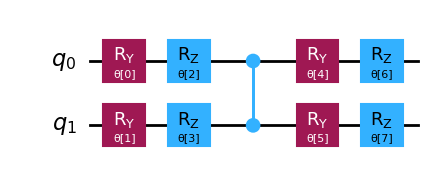

In [ ]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw('mpl')

First, we'll setup a function that calculates the state fidelity -- a percentage of overlap between two states that we'll use as a penalty for VQD:

In [ ]:
import numpy as np

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler):

    def create_fidelity_circuit(circuit_1, circuit_2):

        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
                
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

It's time to write VQD's cost function. As before when we calculated only the ground state, we will determine the lowest energy state using the Estimator primitive. However, as described above, we will now add a penalty term to ensure orthogonality of higher-energy states. That is, for each new excited state, a penalty is added for any overlap between the current variational state and the lower-energy eigenstates already found.

In [ ]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

Note especially that the cost function above refers to the calculate_overlaps function, which actually creates a new quantum circuit. If we want to run on real hardware, that new circuit must also be transpiled, hopefully in an optimal way, to run on the backend we select. Note that transpilation has been built in to the calculate_overlaps or cost_func_vqd functions. Feel free to try modifying the code yourself to build in this additional (and conditional) transpilation - but this will also be done for you in the next lesson.

In this lesson, we will run the VQD algorithm using the Statevector Sampler and Statevector Estimator:

In [ ]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
sampler = Sampler()
estimator = Estimator()

We will introduce an observable to be estimated. In the next lesson we will add some physical context to this, like the excited state of a molecule. It may be helpful to think of this observable as the Hamiltonian of a system that can have excited states, even though this observable has not been chosen to match any particular molecule or atom.

In [ ]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

Here, we set the total number of states we wish to calculate (ground state and excited states, k), and the penalties (betas) for overlap between statevectors that should be orthogonal. The consequences of choosing betas to be too high or too low will be explored a bit in the next lesson. For now, we will simply use those provided below. We will start by using all zeros as our parameters. In your own calculations, you may want to use more clever starting parameters based on your knowledge of the system or on previous calculations.

In [ ]:
k = 3
betas = [33, 33, 33]
x0 = np.zeros(8)

In [ ]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable), method="COBYLA", options={'maxiter': 200,})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.039866358265446
       x: [-1.132e-01  9.052e-02  1.805e-02 -5.802e-08  2.986e-03
           -1.387e-01 -5.869e-08 -1.152e-01]
    nfev: 200
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0358656724353978
       x: [ 1.416e-01 -1.408e-01  4.542e-01  1.151e-01  2.994e+00
            3.189e+00  4.039e-01 -1.007e+00]
    nfev: 174
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.0159132862026
       x: [ 1.416e+00  1.697e+00  6.044e-01  3.451e-01  2.673e+00
           -1.141e+00 -7.029e-01  1.509e+00]
    nfev: 93
   maxcv: 0.0


The values we obtained from the cost function are approximately -6.00, 4.02, and 5.61. The important thing about these results is that the function values are increasing. If we had obtained a first excited state that is lower in energy than our initial, unconstrained calculation of the ground state, that would have indicated an error somewhere in our code.

The values of x are the parameters that yielded a statevector corresponding to each of these costs/energies.

Finally, we note that all three minimizations converged to within the default tolerance of the classical optimizer (here COBYLA). They required 131, 110, and 90 function evaluations, respectively.

## Quantum Sampling Regression (QSR)

One of the main issues with VQE is the multiple calls to a quantum computer that are required to obtain the parameters for each step, including
$k, k−1$, etc. This is especially problematic when access to quantum devices is queued. While a 
`Session` can be used to group multiple iterative calls, an alternative approach is to use sampling. By utilizing more classical resources, we can complete the full optimization process in a single call. This is where Quantum Sampling Regression comes into play. Since access to quantum computers is still a low-offer/high-demand commodity, we find this trade-off to be both possible and convenient for many current studies. This approach harnesses all available classical capabilities while still capturing many of the inner workings and intrinsic properties of quantum computations that do not appear in simulation.

![alt text](../../../img/instances_QSR.svg)

The idea behind QSR is that the cost function $C(\theta) := \langle \psi(\theta) | \hat{H} | \psi(\theta) \rangle$ can be expressed as a Fourier series in the following manner:

$$
C(\vec{\theta}) := \langle \psi(\vec{\theta}) | \hat{H} | \psi(\vec{\theta}) \rangle = a_0 + \sum_{k=1}^{S} \left[ a_k \cos(k\theta) + b_k \sin(k\theta) \right]
$$

Depending on the periodicity and bandwidth of the original function, the set $S$ may be finite or infinite. For the purposes of this discussion, we will assume it is infinite. The next step is to sample the cost function $C(\theta)$ multiple times in order to obtain the Fourier coefficients $\{a_0, a_k, b_k\}_{k=1}^S$. Specifically, since we have $2S + 1$ unknowns, we will need to sample the cost function $2S + 1$ times.

If we then sample the cost function for $2S + 1$ parameter values $\{\theta_1, \dots, \theta_{2S+1}\}$, we can obtain the following system:

$$
\begin{pmatrix}
1 & \cos(\theta_1) & \sin(\theta_1) & \cos(2\theta_1) & \cdots & \sin(S\theta_1) \\
1 & \cos(\theta_2) & \sin(\theta_2) & \cos(2\theta_2) & \cdots & \sin(S\theta_2) \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \cos(\theta_{2S+1}) & \sin(\theta_{2S+1}) & \cos(2\theta_{2S+1}) & \cdots & \sin(S\theta_{2S+1})
\end{pmatrix}
\begin{pmatrix}
a_0 \\ a_1 \\ b_1 \\ a_2 \\ \vdots \\ b_S
\end{pmatrix}
=
\begin{pmatrix}
C(\theta_1) \\ C(\theta_2) \\ \vdots \\ C(\theta_{2S+1})
\end{pmatrix},
$$

that we’ll rewrite as

$$
Fa = c.
$$

In practice, this system is generally not consistent because the cost function values $c$ are not exact. Therefore, it is usually a good idea to normalize them by multiplying them by $F^\dagger$ on the left, which results in:

$$
F^\dagger F a = F^\dagger c.
$$

This new system is always consistent, and its solution is a least-squares solution to the original problem. If we have $k$ parameters instead of just one, and each parameter $\theta^i$ has its own $S_i$ for $i \in \{1, \dots, k\}$, then the total number of samples required is:

$$
T = \prod_{i=1}^{k}(2S_i + 1) \leq \prod_{i=1}^{k}(2S_{\text{max}} + 1) = (2S_{\text{max}} + 1)^n,
$$

where $S_{\text{max}} = \max_i(S_i)$. Furthermore, adjusting $S_{\text{max}}$ as a tunable parameter (instead of inferring it) opens up new possibilities, such as:

- **Oversampling**: to improve accuracy.  
- **Undersampling**: to boost performance by reducing runtime overhead or eliminating local minima.


### QSR’s Theoretical Layout

QSR's layout can be summarized as follows:

- Prepare reference operators $U_R$  
  - We'll go from the state $|0\rangle$ to the reference state $|\rho\rangle$
- Apply the variational form $U_V(\vec{\theta}_{i,j})$ to create an ansatz $U_A(\vec{\theta}_{i,j})$
- Determine the bandwidth associated with each parameter in the ansatz. A upper bound is sufficient.
- Bootstrap at $i = 0$ if we have a similar problem (typically found via classical simulation or sampling)
- Sample the cost function $C(\vec{\theta}) := a_0 + \sum_{k=1}^{S}[a_k \cos(k\theta) + b_k \sin(k\theta)]$ at least $T$ times  
  - $T = \prod_{i=1}^{k}(2S_i + 1) \leq \prod_{i=1}^{k}(2S_{\text{max}} + 1) = (2S_{\text{max}} + 1)^n$
  - Decide whether to oversample/undersample to balance speed vs accuracy by adjusting $T$.
- Compute the Fourier coefficients from the samples (i.e., solve the normalized linear system of equations).
- Solve for the global minimum of the resulting regression function on a classical machine.




## Summary


With this lesson, you learned about multiple variational instances available:

- General layout  
- Introducing weights and penalties to adjust a cost function  
- Exploring undersampling vs oversampling to trade-off speed vs accuracy  

These ideas can be adapted to form a custom variational algorithm that fits your problem. We encourage you to share your results with the community. The next lesson will explore how to use a variational algorithm to solve an application.